<a href="https://colab.research.google.com/github/Mayakshanesht/Semantic-Segmentation/blob/main/Semantic_segmentation_drivableAreaNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#lets mount drive on the google colab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/segmentation/segmentation_course-master/dataset/dataset")
!ls

Mounted at /content/drive
costa_rica_challenge.mp4  labels_3000_160.p	SegmentationTest.h5
images_3000_160.p	  SegmentationTest2.h5


In [2]:
#lets import important python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import cv2
import random
import time

In [3]:
#lets install tensorflow
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
with open('images_3000_160.p','rb') as f:
  images=pickle.load(f)
with open('labels_3000_160.p','rb') as f:
  labels=pickle.load(f) 

In [5]:
label1=[]
for label in labels:
  for x in range(label.shape[0]):
    for y in range(label.shape[1]):
      if(np.all(label[x][y]==[0,0,0])):
        label[x][y]=[0,1,0]
        label1.append(label)

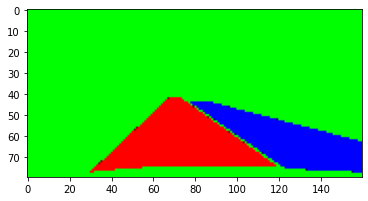

In [6]:
plt.imshow(label1[10])

In [7]:
label1[0].shape

(80, 160, 3)

In [8]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [9]:
images=np.array(images[0:2999])
label1=np.array(label1[0:2999])
images,labels1=shuffle(images,label1)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, label1, test_size=0.15)
n_train = len(X_train)
n_val = len(X_val)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Conv2DTranspose,add,Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
def encoder_decoder_skip_connections(input_shape= (160,80,3), pool_size=(2,2), dropout_rate=0.5):
    """
    Here, build your killer segmentation network.
    Use any technique that can be useful.
    Credits for the architecture: https://towardsdatascience.com/lane-detection-with-deep-learning-part-2-3ba559b5c5af
    """
    # ENCODER
    input_x = Input(shape=(80,160,3))
    x1 = BatchNormalization(input_shape=input_shape)(input_x)
    ## CONV 1
    x = Conv2D(8, (3, 3), strides = (1,1), activation='relu', padding='valid')(x1)
    ## CONV 2 + SKIP CONNECTION
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV 3
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    ## CONV4 + SKIP CONNECTION
    x2 = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x2)
    ## CONV5
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV6
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    ## CONV7
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    # DECODER
    ## UPSAMPLING 7
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 6
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 5
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)

    ## UPSAMPLING 4
    x = add([x2, x])
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 3
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 2
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)

    ## UPSAMPLING 1
    x = Conv2DTranspose(3, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = add([x1, x])
    x = Conv2D(3, (1,1), padding=('valid'), strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = encoder_decoder_skip_connections()
model.summary()





Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 160, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 160, 3)   12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 78, 158, 8)   224         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 156, 16)  1168        conv2d[0][0]                     
______________________________________________________________________________________________

In [13]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics='accuracy')

In [14]:
model.fit(X_train,y_train,epochs=10,validation_data=(X_val,y_val))

Epoch 1/10
80/80 [==============================] - 42s 129ms/step - loss: 0.9081 - accuracy: 0.5874 - val_loss: 1.6479 - val_accuracy: 0.7970
Epoch 2/10
80/80 [==============================] - 8s 104ms/step - loss: 0.3740 - accuracy: 0.8504 - val_loss: 0.4659 - val_accuracy: 0.8422
Epoch 3/10
80/80 [==============================] - 8s 105ms/step - loss: 0.3268 - accuracy: 0.8710 - val_loss: 0.4620 - val_accuracy: 0.8623
Epoch 4/10
80/80 [==============================] - 8s 105ms/step - loss: 0.3085 - accuracy: 0.8808 - val_loss: 0.3454 - val_accuracy: 0.8780
Epoch 5/10
80/80 [==============================] - 9s 106ms/step - loss: 0.2950 - accuracy: 0.8894 - val_loss: 0.3048 - val_accuracy: 0.8856
Epoch 6/10
80/80 [==============================] - 9s 107ms/step - loss: 0.2798 - accuracy: 0.8970 - val_loss: 0.3022 - val_accuracy: 0.8785
Epoch 7/10
80/80 [==============================] - 8s 106ms/step - loss: 0.2666 - accuracy: 0.9020 - val_loss: 0.2767 - val_accuracy: 0.8937
Epoch

In [15]:
def rgb_channel(img, thresholding=False, thresh=230):
    """Threshold the re-drawn images"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B

In [16]:
def run(input_image):
    h,w,d = input_image.shape
    network_image = input_image.copy()
    network_image = cv2.resize(network_image, (160,80), interpolation=cv2.INTER_AREA)
    network_image = network_image[None,:,:,:]
    prediction = model.predict(network_image)[0]*255
    R,G,B = rgb_channel(prediction)
    blank = np.zeros_like(R).astype(np.uint8)
    lane_image = np.dstack((R,blank, B))
    lane_image = cv2.resize(lane_image, (w,h))
    result = cv2.addWeighted(input_image, 1, lane_image.astype(np.uint8), 1, 0)
    return result

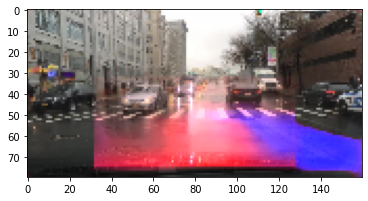

In [17]:
predict_image = images[0]
plt.imshow(run(predict_image))
plt.show()

In [18]:
from moviepy.editor import VideoFileClip

video_file = "/content/drive/My Drive/segmentation/segmentation_course-master/dataset/dataset/costa_rica_challenge.mp4"
clip = VideoFileClip(video_file)
white_clip = clip.fl_image(run)
%time white_clip.write_videofile("/content/drive/My Drive/segmentation/movie_track8.mp4",audio=False)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2138112/45929032 bytes (4.7%)5398528/45929032 bytes (11.8%)8716288/45929032 bytes (19.0%)12148736/45929032 bytes (26.5%)15556608/45929032 bytes (33.9%)18964480/45929032 bytes (41.3%)22364160/45929032 bytes (48.7%)25591808/45929032 bytes (55.7%)29130752/45929032 bytes (63.4%)32595968/45929032 bytes (71.0%)35938304/45929032 bytes (78.2%)39043072/45929032 bytes (85.0%)

100%|█████████▉| 1839/1840 [10:17<00:00,  2.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/segmentation/movie_track8.mp4 

CPU times: user 3min 32s, sys: 17.7 s, total: 3min 50s
Wall time: 10min 27s
